In [2]:
# --- 0) Imports
import os
import numpy as np
import SimpleITK as sitk
import torchio as tio
import matplotlib.pyplot as plt
from typing import Tuple
import torch
# --- 1) Config: set your paths here
PATH_IMAGE = "/home/mohanty/VSCODE_PROJECTS/Medical-Detection3d-Toolkit backup/detection3d/data/Nasion_1320/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2.nii.gz"   # e.g., cropped CBCT
PATH_LABEL = "/home/mohanty/VSCODE_PROJECTS/Medical-Detection3d-Toolkit backup/detection3d/data/Nasion_1320/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2_landmark_mask.nii.gz"   # e.g., segmentation/landmark mask; optional but recommended
RNG_SEED   = 42                             # reproducibility for random aug

torch.manual_seed(RNG_SEED)          # for TorchIO / PyTorch randomness
np.random.seed(RNG_SEED)

# --- 5) Define ONE augmentation (swap this block to try others)
# Examples you can try:
#   tio.RandomFlip(axes=(0,1,2), p=1.0)
#   tio.RandomNoise(mean=0.0, std=0.02, p=1.0)
#   tio.RandomGamma(log_gamma=(-0.3, 0.3), p=1.0)
#   tio.RandomElasticDeformation(num_control_points=5, max_displacement=8, p=1.0, locked_borders=2)
#   tio.RandomMotion(num_transforms=2, p=1.0)



In [ ]:
# --- 0) Imports
import os
import numpy as np
import SimpleITK as sitk
import torchio as tio
import matplotlib.pyplot as plt
from typing import Tuple
import torch
# --- 1) Config: set your paths here
PATH_IMAGE = "/home/mohanty/VSCODE_PROJECTS/Medical-Detection3d-Toolkit backup/detection3d/data/Nasion_1000k/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2.nii.gz"   # e.g., cropped CBCT
PATH_LABEL = "/home/mohanty/VSCODE_PROJECTS/Medical-Detection3d-Toolkit backup/detection3d/data/Nasion_1000k/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2_landmark_mask.nii.gz"   # e.g., segmentation/landmark mask; optional but recommended
RNG_SEED   = 42                             # reproducibility for random aug

torch.manual_seed(RNG_SEED)          # for TorchIO / PyTorch randomness
np.random.seed(RNG_SEED)

# --- 5) Define ONE augmentation (swap this block to try others)
# Examples you can try:
  # tio.RandomFlip(axes=(0,1,2), p=1.0)
#   tio.RandomNoise(mean=0.0, std=0.02, p=1.0)
#   tio.RandomGamma(log_gamma=(-0.3, 0.3), p=1.0)
#   tio.RandomElasticDeformation(num_control_points=5, max_displacement=8, p=1.0, locked_borders=2)
#   tio.RandomMotion(num_transforms=2, p=1.0)



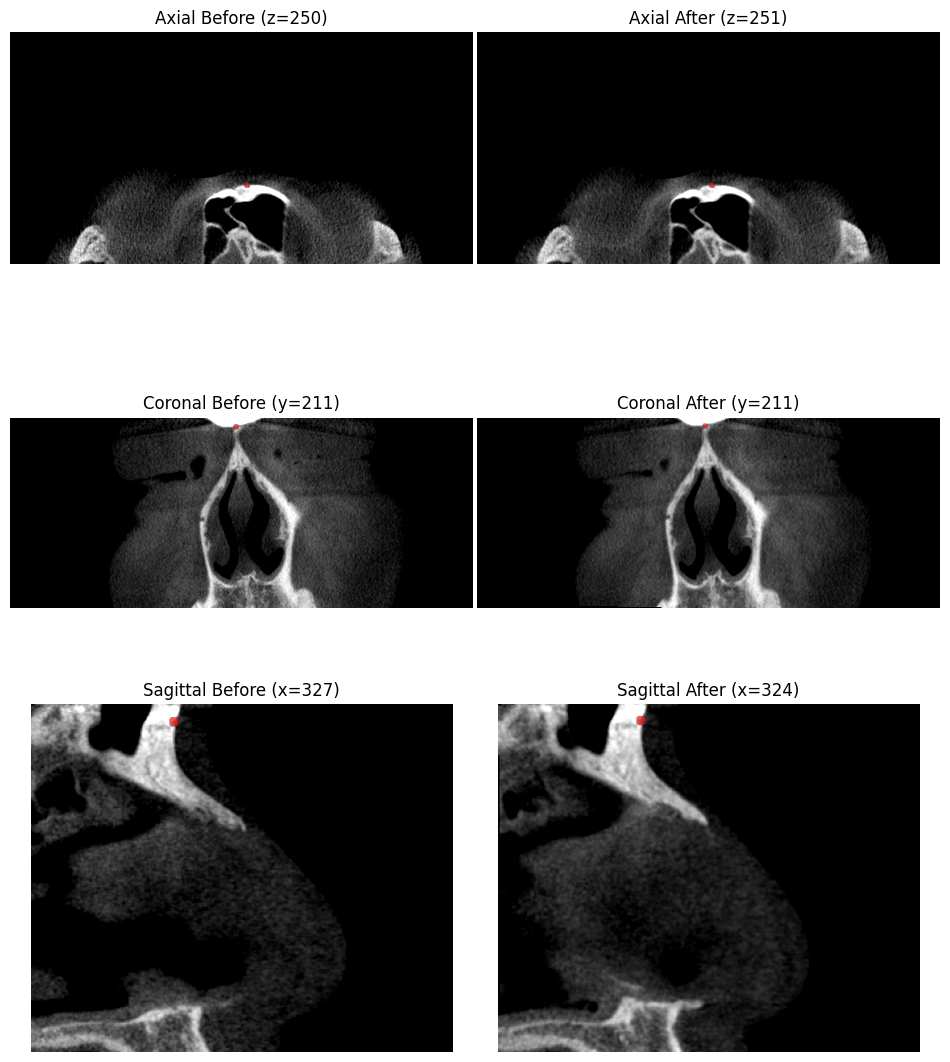

In [30]:
# --- 0) Imports
import os
import numpy as np
import SimpleITK as sitk
import torchio as tio
import matplotlib.pyplot as plt

# --- 1) Paths / config
RNG_SEED = 42  # set for deterministic aug; change/remove for randomness

assert os.path.exists(PATH_IMAGE), f"Image not found: {PATH_IMAGE}"
assert os.path.exists(PATH_LABEL), f"Label not found: {PATH_LABEL}"

# --- 2) Utilities
def sitk_to_numpy_chwd(img: sitk.Image) -> np.ndarray:
    """SimpleITK (z,y,x) -> numpy (1,h,w,d) float32 for TorchIO."""
    arr_zyx = sitk.GetArrayFromImage(img).astype(np.float32)  # (z,y,x)
    arr_yxz = np.transpose(arr_zyx, (1, 2, 0))                # (y,x,z)
    return arr_yxz[None, ...]                                 # (1,h,w,d)

def numpy_chwd_to_sitk(arr: np.ndarray, like: sitk.Image) -> sitk.Image:
    """NumPy (1,h,w,d) -> SimpleITK (z,y,x) with metadata copied from 'like'."""
    arr_yxz = arr.squeeze(0)                                  # (h,w,d)
    arr_zyx = np.transpose(arr_yxz, (2, 0, 1))                # (z,y,x)
    out = sitk.GetImageFromArray(arr_zyx)
    out.CopyInformation(like)
    return out

def robust_window_from_image(img: sitk.Image, use_otsu=True, p_low=0.5, p_high=99.5):
    """Compute (vmin, vmax) from non-air voxels. Falls back safely if needed."""
    arr = sitk.GetArrayFromImage(img).astype(np.float32)  # (z,y,x)
    mask = arr > 0
    if use_otsu:
        try:
            mask = sitk.GetArrayFromImage(sitk.OtsuThreshold(img, 0, 1)).astype(bool)
        except Exception:
            pass
    nz = arr[mask]
    if nz.size == 0:
        vmin, vmax = float(arr.min()), float(arr.max())
    else:
        vmin, vmax = np.percentile(nz, (p_low, p_high))
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            vmin, vmax = float(arr.min()), float(arr.max())
    return vmin, vmax

def landmark_index_from_mask(mask_zyx: np.ndarray):
    """
    Return (z,y,x) index for landmark from a binary/label mask.
    If multiple voxels: integer-rounded centroid.
    If empty: center of volume.
    """
    coords = np.argwhere(mask_zyx > 0)  # (N, 3) in z,y,x order
    if coords.size == 0:
        zyx = np.array(mask_zyx.shape) // 2
    else:
        zyx = np.round(coords.mean(axis=0)).astype(int)
        zyx = np.clip(zyx, [0, 0, 0], np.array(mask_zyx.shape) - 1)
    return tuple(int(v) for v in zyx)

def _panel(ax, img2d, msk2d, title, vmin, vmax, alpha_mask=0.35, rotate180=False):
    if rotate180:
        img2d = np.rot90(img2d, 2)
        msk2d = np.rot90(msk2d, 2)

    ax.imshow(img2d, cmap="gray", vmin=vmin, vmax=vmax)
    if msk2d.max() > 0:
        overlay = np.zeros((*msk2d.shape, 4))   # RGBA
        overlay[msk2d > 0] = [0.9, 0.1, 0.1, 0.7]  # dark red, 70% opaque
        ax.imshow(overlay)
    ax.set_title(title)
    ax.axis("off")


def show_orthogonal_centered_on_landmark(img_b, msk_b, img_a, msk_a, vmin, vmax,
                                         alpha_mask=0.35, rotate_non_axial=True):
    """
    Show axial/coronal/sagittal Before vs After, each centered on that
    volume's landmark (so indices can differ across columns).
    """
    ib = sitk.GetArrayFromImage(img_b)  # (z,y,x)
    mb = sitk.GetArrayFromImage(msk_b)
    ia = sitk.GetArrayFromImage(img_a)
    ma = sitk.GetArrayFromImage(msk_a)

    zb, yb, xb = landmark_index_from_mask(mb)
    za, ya, xa = landmark_index_from_mask(ma)

    fig, axes = plt.subplots(3, 2, figsize=(12, 14))

    # fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # shorter figure

    # Axial
    _panel(axes[0,0], ib[zb], mb[zb], f"Axial Before (z={zb})", vmin, vmax, alpha_mask)
    _panel(axes[0,1], ia[za], ma[za], f"Axial After (z={za})",  vmin, vmax, alpha_mask)

    # Coronal
    _panel(axes[1,0], ib[:, yb, :], mb[:, yb, :], f"Coronal Before (y={yb})",
        vmin, vmax, alpha_mask, rotate180=True)
    _panel(axes[1,1], ia[:, ya, :], ma[:, ya, :], f"Coronal After (y={ya})",
        vmin, vmax, alpha_mask, rotate180=True)

    # Sagittal
    _panel(axes[2,0], ib[:, :, xb], mb[:, :, xb], f"Sagittal Before (x={xb})",
        vmin, vmax, alpha_mask, rotate180=True)
    _panel(axes[2,1], ia[:, :, xa], ma[:, :, xa], f"Sagittal After (x={xa})",
        vmin, vmax, alpha_mask, rotate180=True)

    # tighten spacing
    plt.subplots_adjust(wspace=0.01, hspace=0.05)
    plt.show()

    # plt.tight_layout(); plt.show()

def physical_z_y_x_titles(img: sitk.Image, z, y, x):
    """Return physical mm coordinates for the selected indices (informative only)."""
    spacing = img.GetSpacing()      # (sx, sy, sz) in SITK's (x,y,z) order
    origin  = img.GetOrigin()       # (ox, oy, oz)
    z_mm = origin[2] + z * spacing[2]
    y_mm = origin[1] + y * spacing[1]
    x_mm = origin[0] + x * spacing[0]
    return x_mm, y_mm, z_mm

# --- 3) Load NIfTI
img_sitk = sitk.ReadImage(PATH_IMAGE)
msk_sitk = sitk.ReadImage(PATH_LABEL)

# --- 4) TorchIO subject
img_np = sitk_to_numpy_chwd(img_sitk)
msk_np = sitk_to_numpy_chwd(msk_sitk)
subject = tio.Subject(
    image=tio.ScalarImage(tensor=img_np),
    mask=tio.LabelMap(tensor=msk_np)
)

# --- 5) One augmentation (change this to try others)
transform = tio.RandomAffine(
    scales=(1.05, 1.05),
    degrees=(10, 10, 10),
    translation=(5, 5, 0),
    p=1.0
)
# deterministic: pass random_state
# aug_subject = transform(subject,)  

# transform2 = tio.RandomFlip(axes=(1), flip_probability=1.0)
# aug_subject = transform2(aug_subject)


# transform3 = tio.RandomMotion(degrees= 25, translation = 0 ,num_transforms=10, p=1.0, include=('image',),)
# aug_subject = transform3(aug_subject)
transform3 = tio.RandomElasticDeformation(
    num_control_points=7,
    max_displacement=10,
    locked_borders=2,   # don’t move edges (to avoid unrealistic warping at image borders)
    include=('image', 'mask'),
    p=0.5
)

aug_subject = transform3(subject)



# --- 6) Back to SimpleITK
img_aug_sitk = numpy_chwd_to_sitk(aug_subject["image"].data.numpy(), like=img_sitk)
msk_aug_sitk = numpy_chwd_to_sitk(aug_subject["mask"].data.numpy(),  like=msk_sitk)

# --- 7) Window once from original; reuse
vmin, vmax = robust_window_from_image(img_sitk, use_otsu=True, p_low=0.5, p_high=99.5)

# --- 8) Show orthogonal views centered on landmark (rotates coronal/sagittal 180°)
show_orthogonal_centered_on_landmark(
    img_sitk, msk_sitk, img_aug_sitk, msk_aug_sitk, vmin, vmax,
    alpha_mask=0.35, rotate_non_axial=True
)


Saved transformed files:
  affine:
    image: transformed/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2__affine.nii.gz
    mask : transformed/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2_landmark_mask__affine.nii.gz
  flip_lr:
    image: transformed/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2__flip_lr.nii.gz
    mask : transformed/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2_landmark_mask__flip_lr.nii.gz
  motion:
    image: transformed/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2__motion.nii.gz
    mask : transformed/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2_landmark_mask__motion.nii.gz
  elastic:
    image: transformed/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2__elastic.nii.gz
    mask : transformed/0a7bfd903ff385676c0cbfc026702172629da11cbb516e58ca89084d85a118d2_landmark_mask__elastic.nii.gz
  pad16:
    image: transformed/0a7bfd903ff385676

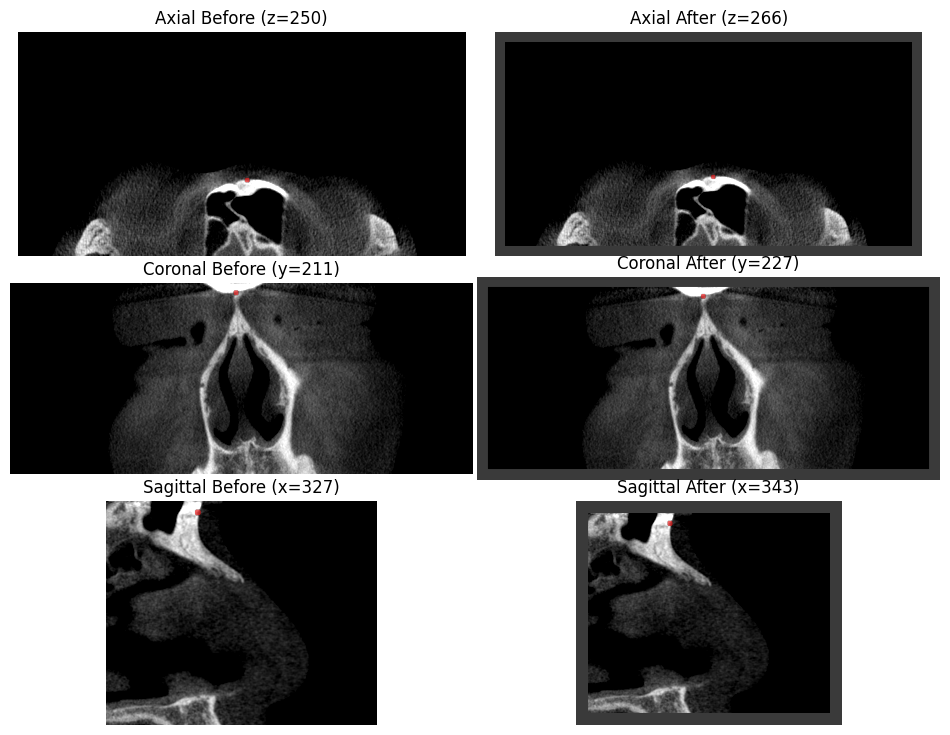

In [37]:
# --- 0) Imports
import os
import numpy as np
import SimpleITK as sitk
import torchio as tio
import matplotlib.pyplot as plt

# --- 1) Paths / config
RNG_SEED = 42  # base seed for deterministic runs
SAVE_DIR = "transformed"
os.makedirs(SAVE_DIR, exist_ok=True)

assert os.path.exists(PATH_IMAGE), f"Image not found: {PATH_IMAGE}"
assert os.path.exists(PATH_LABEL), f"Label not found: {PATH_LABEL}"

# --- 2) Utilities (unchanged)
def sitk_to_numpy_chwd(img: sitk.Image) -> np.ndarray:
    """SimpleITK (z,y,x) -> numpy (1,h,w,d) float32 for TorchIO."""
    arr_zyx = sitk.GetArrayFromImage(img).astype(np.float32)  # (z,y,x)
    arr_yxz = np.transpose(arr_zyx, (1, 2, 0))                # (y,x,z)
    return arr_yxz[None, ...]                                 # (1,h,w,d)

def numpy_chwd_to_sitk(arr: np.ndarray, like: sitk.Image) -> sitk.Image:
    """NumPy (1,h,w,d) -> SimpleITK (z,y,x). Copy all metadata iff size matches."""
    arr_yxz = arr.squeeze(0)                      # (h,w,d)
    arr_zyx = np.transpose(arr_yxz, (2, 0, 1))    # (z,y,x)
    out = sitk.GetImageFromArray(arr_zyx)

    # Always keep voxel geometry consistent
    out.SetSpacing(like.GetSpacing())
    out.SetDirection(like.GetDirection())

    # CopyInformation only if the sizes match
    if out.GetSize() == like.GetSize():
        out.CopyInformation(like)
    else:
        # Safe default: keep the same origin. (See below if you want precise origin for padding.)
        out.SetOrigin(like.GetOrigin())

    return out

def robust_window_from_image(img: sitk.Image, use_otsu=True, p_low=0.5, p_high=99.5):
    """Compute (vmin, vmax) from non-air voxels. Falls back safely if needed."""
    arr = sitk.GetArrayFromImage(img).astype(np.float32)  # (z,y,x)
    mask = arr > 0
    if use_otsu:
        try:
            mask = sitk.GetArrayFromImage(sitk.OtsuThreshold(img, 0, 1)).astype(bool)
        except Exception:
            pass
    nz = arr[mask]
    if nz.size == 0:
        vmin, vmax = float(arr.min()), float(arr.max())
    else:
        vmin, vmax = np.percentile(nz, (p_low, p_high))
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            vmin, vmax = float(arr.min()), float(arr.max())
    return vmin, vmax

def landmark_index_from_mask(mask_zyx: np.ndarray):
    coords = np.argwhere(mask_zyx > 0)  # (N, 3) in z,y,x order
    if coords.size == 0:
        zyx = np.array(mask_zyx.shape) // 2
    else:
        zyx = np.round(coords.mean(axis=0)).astype(int)
        zyx = np.clip(zyx, [0, 0, 0], np.array(mask_zyx.shape) - 1)
    return tuple(int(v) for v in zyx)

def _panel(ax, img2d, msk2d, title, vmin, vmax, alpha_mask=0.35, rotate180=False):
    if rotate180:
        img2d = np.rot90(img2d, 2)
        msk2d = np.rot90(msk2d, 2)
    ax.imshow(img2d, cmap="gray", vmin=vmin, vmax=vmax)
    if msk2d.max() > 0:
        overlay = np.zeros((*msk2d.shape, 4))   # RGBA
        overlay[msk2d > 0] = [0.9, 0.1, 0.1, 0.7]  # dark red, 70% opaque
        ax.imshow(overlay)
    ax.set_title(title)
    ax.axis("off")

def show_orthogonal_centered_on_landmark(img_b, msk_b, img_a, msk_a, vmin, vmax,
                                         alpha_mask=0.35, rotate_non_axial=True):
    ib = sitk.GetArrayFromImage(img_b)  # (z,y,x)
    mb = sitk.GetArrayFromImage(msk_b)
    ia = sitk.GetArrayFromImage(img_a)
    ma = sitk.GetArrayFromImage(msk_a)

    zb, yb, xb = landmark_index_from_mask(mb)
    za, ya, xa = landmark_index_from_mask(ma)

    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # tighter figure

    # Axial
    _panel(axes[0,0], ib[zb], mb[zb], f"Axial Before (z={zb})", vmin, vmax, alpha_mask)
    _panel(axes[0,1], ia[za], ma[za], f"Axial After (z={za})",  vmin, vmax, alpha_mask)

    # Coronal
    _panel(axes[1,0], ib[:, yb, :], mb[:, yb, :], f"Coronal Before (y={yb})",
        vmin, vmax, alpha_mask, rotate180=True)
    _panel(axes[1,1], ia[:, ya, :], ma[:, ya, :], f"Coronal After (y={ya})",
        vmin, vmax, alpha_mask, rotate180=True)

    # Sagittal
    _panel(axes[2,0], ib[:, :, xb], mb[:, :, xb], f"Sagittal Before (x={xb})",
        vmin, vmax, alpha_mask, rotate180=True)
    _panel(axes[2,1], ia[:, :, xa], ma[:, :, xa], f"Sagittal After (x={xa})",
        vmin, vmax, alpha_mask, rotate180=True)

    plt.subplots_adjust(wspace=0.01, hspace=0.05)
    plt.show()

def physical_z_y_x_titles(img: sitk.Image, z, y, x):
    spacing = img.GetSpacing()      # (sx, sy, sz) in SITK's (x,y,z) order
    origin  = img.GetOrigin()       # (ox, oy, oz)
    z_mm = origin[2] + z * spacing[2]
    y_mm = origin[1] + y * spacing[1]
    x_mm = origin[0] + x * spacing[0]
    return x_mm, y_mm, z_mm

# --- 3) Load NIfTI
img_sitk = sitk.ReadImage(PATH_IMAGE)
msk_sitk = sitk.ReadImage(PATH_LABEL)

# --- 4) TorchIO subject (original)
img_np = sitk_to_numpy_chwd(img_sitk)
msk_np = sitk_to_numpy_chwd(msk_sitk)
base_subject = tio.Subject(
    image=tio.ScalarImage(tensor=img_np),
    mask=tio.LabelMap(tensor=msk_np)
)

# --- 5) Define independent transforms (do NOT chain)
# Note: TorchIO sees (C,H,W,D) = (1,y,x,z). So:
#   axes=(1,) -> flip along y (A<->P)
#   axes=(2,) -> flip along x (L<->R)  <-- sagittal mirror
#   axes=(3,) -> flip along z (S<->I)
transforms = {
    "affine": tio.RandomAffine(
        scales=(1.05, 1.05),
        degrees=(10, 10, 10),
        translation=(5, 5, 0),
        p=1.0
    ),
    "flip_lr": tio.RandomFlip(
        axes=(1,),                 # left<->right
        flip_probability=1.0
    ),
    "motion": tio.RandomMotion(
        degrees=25,
        translation=0,
        num_transforms=10,
        include=('image',),        # intensity-only: image only
        p=1.0
    ),
    "elastic": tio.RandomElasticDeformation(
        num_control_points=7,
        max_displacement=10,
        locked_borders=2,
        include=('image',), # spatial: apply to both
        p=1.0
    ),
    "pad16": tio.Pad(
    (16, 16, 16),   # pad 16 voxels in (x,y,z)
    padding_mode=0, # value for padded voxels (air = 0)
    include=('image', 'mask')
)

}

# --- 6) Helper to apply ONE transform to the ORIGINAL subject and save outputs
def apply_and_save(subject: tio.Subject, name: str, transform: tio.Transform, seed: int):
    # Apply to a fresh copy to ensure independence
    aug = transform(subject)

    # Convert back to SimpleITK
    img_aug = numpy_chwd_to_sitk(aug["image"].data.numpy(), like=img_sitk)
    msk_aug = numpy_chwd_to_sitk(aug["mask"].data.numpy(),  like=msk_sitk)

    # Build filenames
    img_base = os.path.splitext(os.path.basename(PATH_IMAGE))[0].replace(".nii","")
    msk_base = os.path.splitext(os.path.basename(PATH_LABEL))[0].replace(".nii","")

    out_img = os.path.join(SAVE_DIR, f"{img_base}__{name}.nii.gz")
    out_msk = os.path.join(SAVE_DIR, f"{msk_base}__{name}.nii.gz")

    # Save
    sitk.WriteImage(img_aug, out_img)
    sitk.WriteImage(msk_aug, out_msk)

    return img_aug, msk_aug, out_img, out_msk

# --- 7) Run each transform independently and save
saved_paths = {}
last_img_aug, last_msk_aug = None, None
for i, (tname, tform) in enumerate(transforms.items()):
    img_aug_sitk, msk_aug_sitk, p_img, p_msk = apply_and_save(
        base_subject, tname, tform, seed=RNG_SEED + i
    )
    saved_paths[tname] = (p_img, p_msk)
    # remember the last one for optional visualization
    last_img_aug, last_msk_aug = img_aug_sitk, msk_aug_sitk

print("Saved transformed files:")
for k, (pi, pm) in saved_paths.items():
    print(f"  {k}:")
    print(f"    image: {pi}")
    print(f"    mask : {pm}")

# --- 8) Optional: visualize the LAST transformed pair vs original
vmin, vmax = robust_window_from_image(img_sitk, use_otsu=True, p_low=0.5, p_high=99.5)
show_orthogonal_centered_on_landmark(
    img_sitk, msk_sitk, last_img_aug, last_msk_aug, vmin, vmax,
    alpha_mask=0.35, rotate_non_axial=True
)
